<a href="https://colab.research.google.com/github/matardoky/DL__kERAS/blob/master/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !  git clone https://github.com/EFS-OpenSource/calibration-framework
 %cd /content/calibration-framework
! python3 -m pip install .

Cloning into 'calibration-framework'...
remote: Enumerating objects: 2459, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 2459 (delta 235), reused 201 (delta 143), pack-reused 2125
Receiving objects: 100% (2459/2459), 32.12 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (1701/1701), done.
/content/calibration-framework
Processing /content/calibration-framework
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 22.1 MB/s eta 0:00:00
  Created wheel for netcal: filename=netcal-1.3.5-py3-none-any.

In [2]:
! pip install tensorflow tensorflow_probability==0.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.4 MB/s eta 0:00:00
Reason for being yanked: TFP 0.20 should require Python 3.8+
  Attempting uninstall: tensorflow_probability
    Found existing installation: tensorflow-probability 0.20.1
    Uninstalling tensorflow-probability-0.20.1:
      Successfully uninstalled tensorflow-probability-0.20.1


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
print("Tensorflow version:", tf.__version__)

! pip install numpy
import numpy as np

Tensorflow version: 2.12.0


In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images, test_images = train_images / 255, test_images / 255



170498071/170498071 [==============================] - 14s 0us/step


In [5]:
train_images.shape, train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [6]:
train_labels, test_labels = tf.keras.utils.to_categorical(train_labels), tf.keras.utils.to_categorical(test_labels)

train_labels.shape, test_labels.shape

((50000, 10), (10000, 10))

In [7]:
models = []

def create_lenet_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=train_images.shape[1:]))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))
    #model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))
    #model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dense(10))

    return model

def create_resnet_model():
    model = tf.keras.models.Sequential()
    base_model = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=train_images.shape[1:]
    )
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(10))

    return model

def create_vgg_model():
    model = tf.keras.models.Sequential()
    base_model = tf.keras.applications.vgg19.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=train_images.shape[1:]
    )
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(10))

    return model


def create_densenet_model():
    model = tf.keras.models.Sequential()
    base_model = tf.keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=train_images.shape[1:]
    )
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(10))

    return model

In [8]:
lenet_model = create_lenet_model()
resnet_model = create_resnet_model()
vgg_model = create_vgg_model()
densenet_model = create_densenet_model()


models.append(("lenet", lenet_model))
models.append(("resnet", resnet_model))
#models.append(("vgg", vgg_model))
models.append(("densenet", densenet_model))


74836368/74836368 [==============================] - 5s 0us/step


In [9]:
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [10]:
def train_model(model, name):

  print(f"Train {name}:")

  model.compile(optimizer="adam",
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Entraînement du modèle
  model.fit(train_images, train_labels, epochs=10, batch_size=128)

  # Évaluation du modèle
  _, accuracy = model.evaluate(test_images, test_labels)
  print(f"Test Accuracy of {name}: {accuracy:.4f}")


In [11]:
for name, model in models:
  train_model(model, name)

Train lenet:
Epoch 1/10
391/391 [==============================] - 14s 5ms/step - loss: 1.7843 - accuracy: 0.3501
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 1.5025 - accuracy: 0.4556
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 1.3913 - accuracy: 0.4989
Epoch 4/10
391/391 [==============================] - 2s 5ms/step - loss: 1.3265 - accuracy: 0.5241
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 1.2693 - accuracy: 0.5457
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 1.2291 - accuracy: 0.5606
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1892 - accuracy: 0.5749
Epoch 8/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1529 - accuracy: 0.5907
Epoch 9/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1250 - accuracy: 0.6007
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 1.1749 - ac

In [12]:
from netcal.presentation import ReliabilityDiagram
from netcal.metrics import ECE
from netcal.scaling import TemperatureScaling
from netcal.binning import HistogramBinning, IsotonicRegression, BBQ

n_bins =15

ece = ECE(n_bins)

histogram_binning = HistogramBinning(bins=n_bins)
isotonic_regression = IsotonicRegression()
bbq = BBQ()
temperature_scaling = TemperatureScaling()

diagram = ReliabilityDiagram(n_bins)


In [13]:
def evaluate_calibrate_plot(model,name, calibration_method):

  #_, accuracy = model.evaluate(test_images, test_labels)
  #print(f"Test Accuracy of {name}: {accuracy:.4f}")

  # Prédictions
  probability_model = tf.keras.models.Sequential([
      model,
      tf.keras.layers.Softmax()
    ])
  confidences = probability_model.predict(test_images)
  ground_truth = np.argmax(test_labels, axis=1)


  # Calibration
  calibration_method.fit(confidences, ground_truth)
  calibrated_predictions = calibration_method.transform(confidences)

  # Calcul de l'ECE
  ece = ECE(bins=10)
  uncalibrated_score = ece.measure(confidences, ground_truth)
  calibrated_score = ece.measure(calibrated_predictions, ground_truth)

  # Plot
  diagram.plot(confidences, ground_truth, filename=f"{name}_Uncalibrated.png")
  diagram.plot(calibrated_predictions, ground_truth, filename=f"{name}_Calibrated.png")

  # Résultats
  print(f"{name} Uncalibrated ECE: {uncalibrated_score:.4f}")
  print(f"{name} Calibrated ECE: {calibrated_score:.4f}")



**Histogram binning**

313/313 [==============================] - 1s 2ms/step
lenet Uncalibrated ECE: 0.0166
lenet Calibrated ECE: 0.0204
313/313 [==============================] - 4s 8ms/step
resnet Uncalibrated ECE: 0.0296
resnet Calibrated ECE: 0.0212
313/313 [==============================] - 11s 26ms/step
densenet Uncalibrated ECE: 0.0937
densenet Calibrated ECE: 0.0251


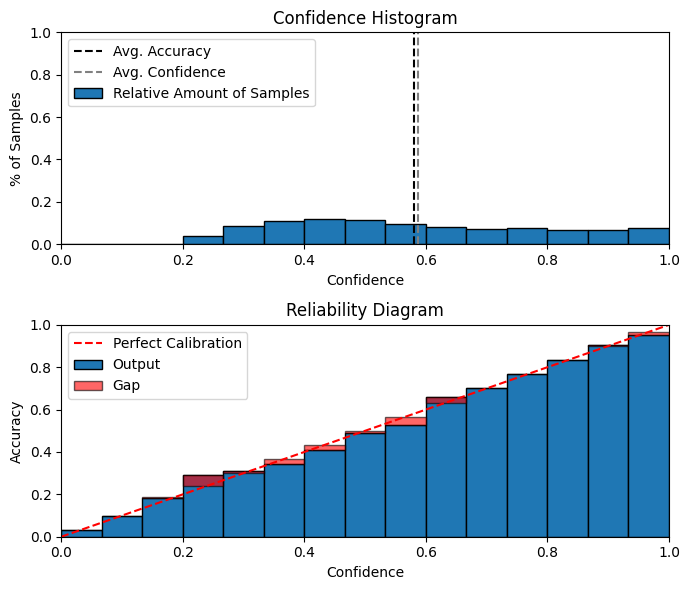

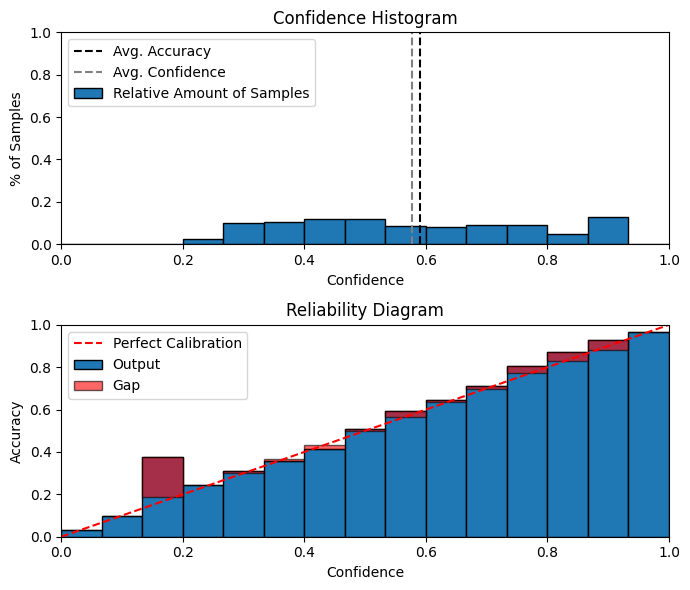

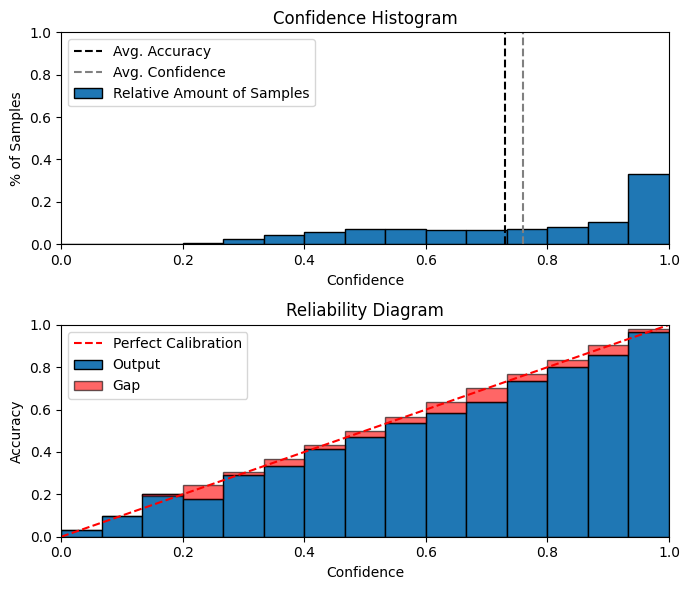

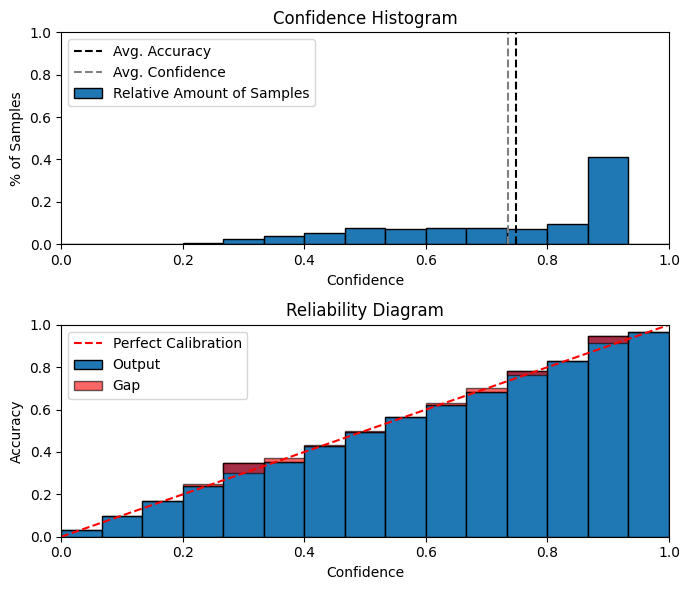

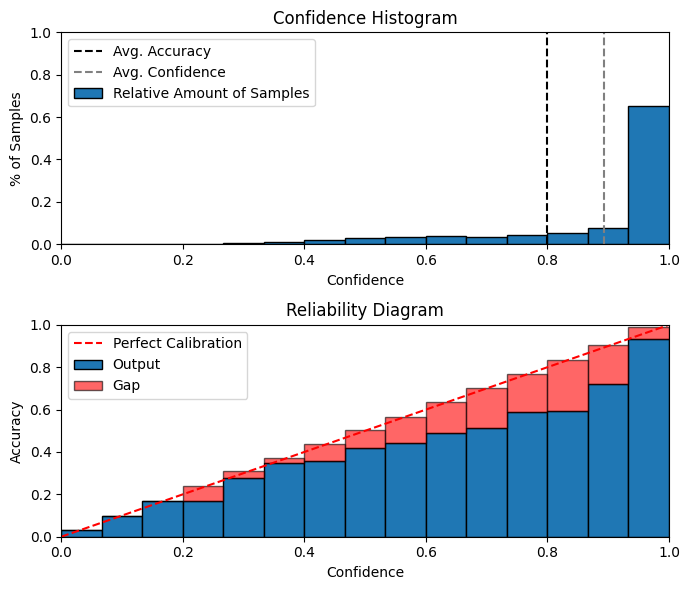

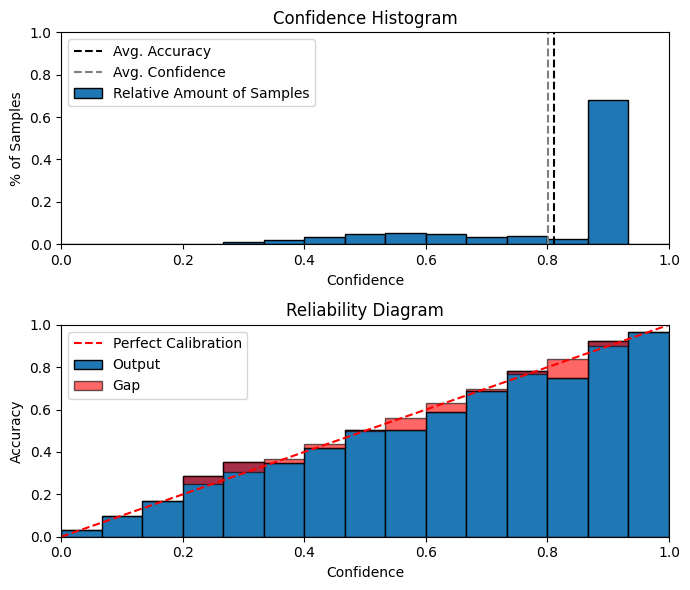

In [14]:
for name, model in models:

  evaluate_calibrate_plot(model, name, histogram_binning)


**Isotonic regression**

313/313 [==============================] - 1s 2ms/step
lenet Uncalibrated ECE: 0.0166
lenet Calibrated ECE: 0.0110
313/313 [==============================] - 4s 9ms/step
resnet Uncalibrated ECE: 0.0296
resnet Calibrated ECE: 0.0114
313/313 [==============================] - 11s 25ms/step
densenet Uncalibrated ECE: 0.0937
densenet Calibrated ECE: 0.0152


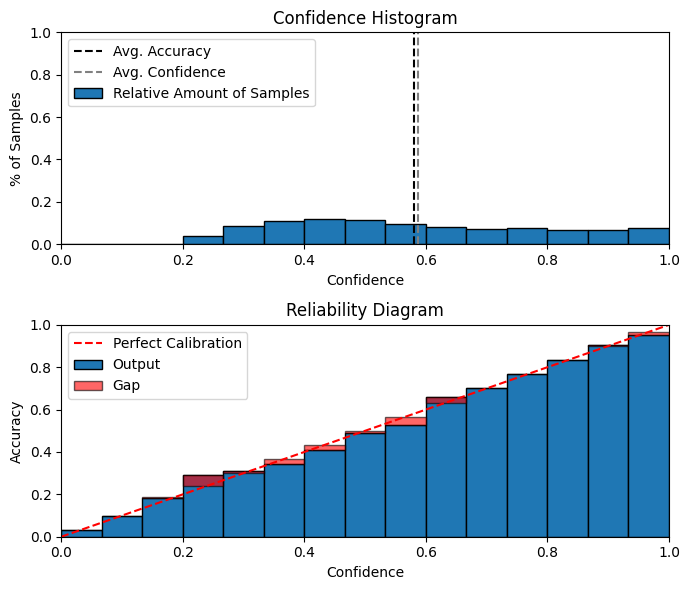

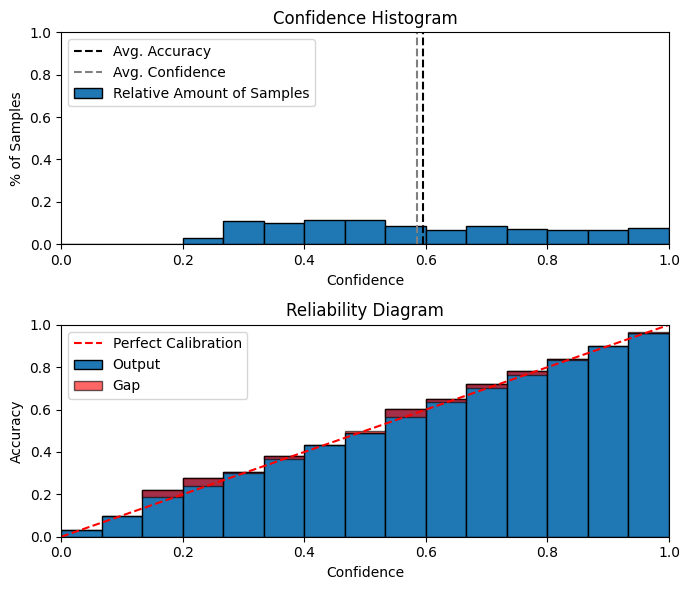

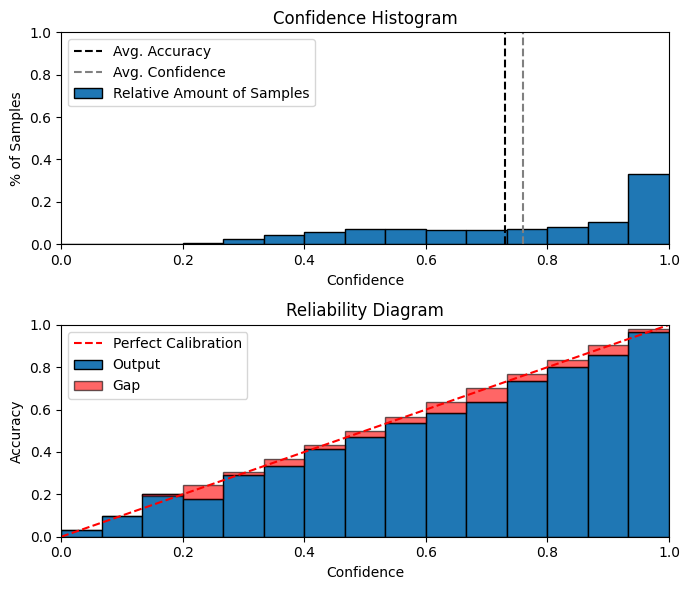

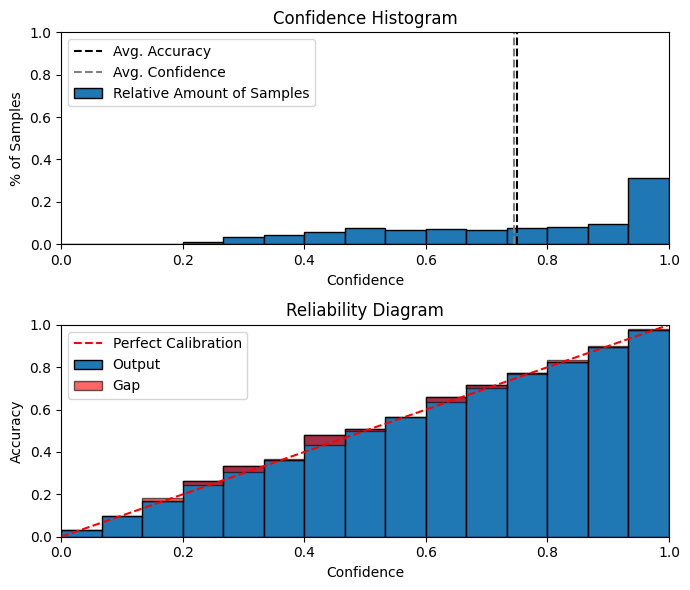

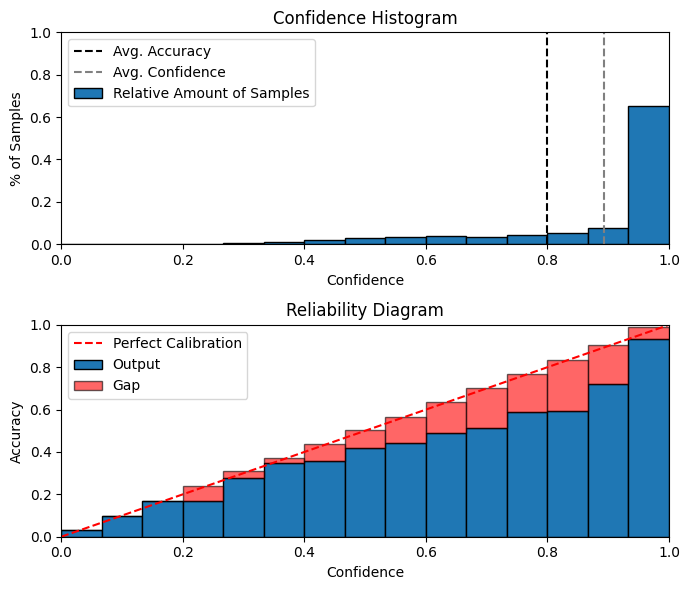

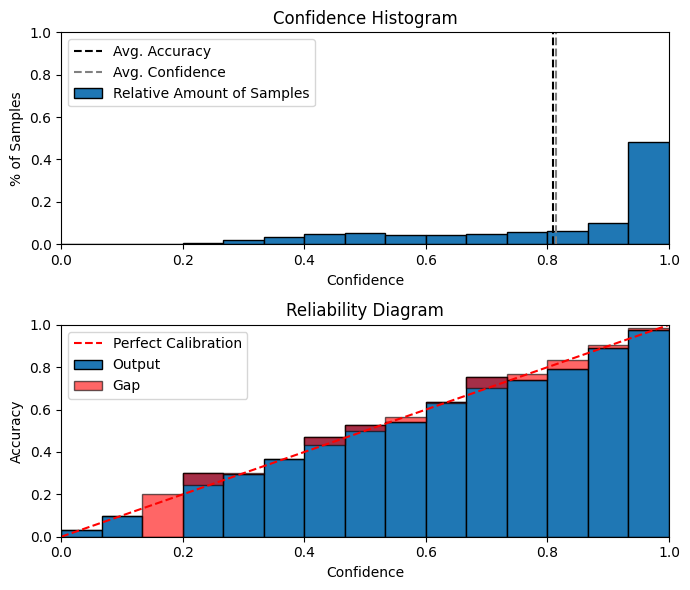

In [15]:
for name, model in models:

  evaluate_calibrate_plot(model, name, isotonic_regression)


**BBQ**

313/313 [==============================] - 1s 2ms/step


100%|██████████| 215/215 [00:00<00:00, 913.58it/s]


lenet Uncalibrated ECE: 0.0166
lenet Calibrated ECE: 0.0192
313/313 [==============================] - 4s 9ms/step


100%|██████████| 215/215 [00:00<00:00, 953.99it/s]


resnet Uncalibrated ECE: 0.0296
resnet Calibrated ECE: 0.0185
313/313 [==============================] - 11s 20ms/step


100%|██████████| 215/215 [00:00<00:00, 993.91it/s] 


densenet Uncalibrated ECE: 0.0937
densenet Calibrated ECE: 0.0274


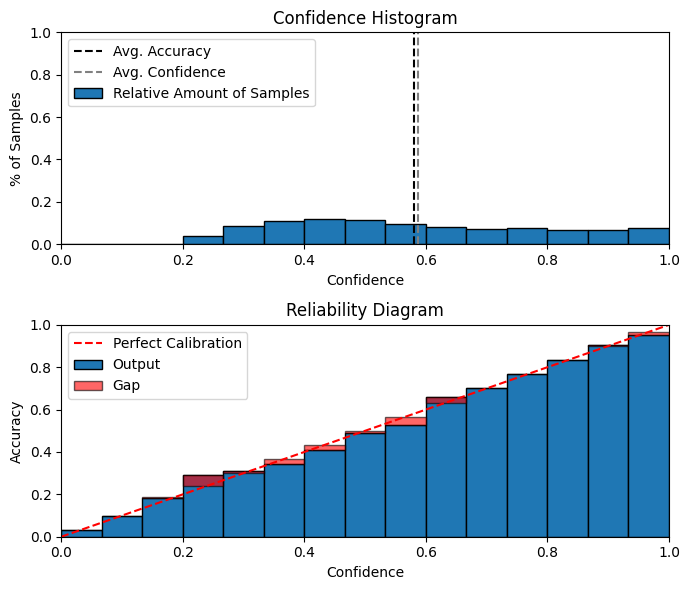

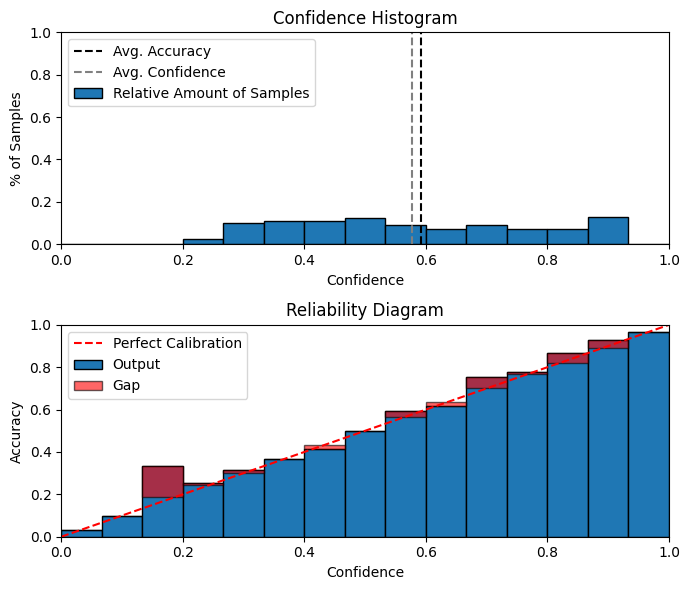

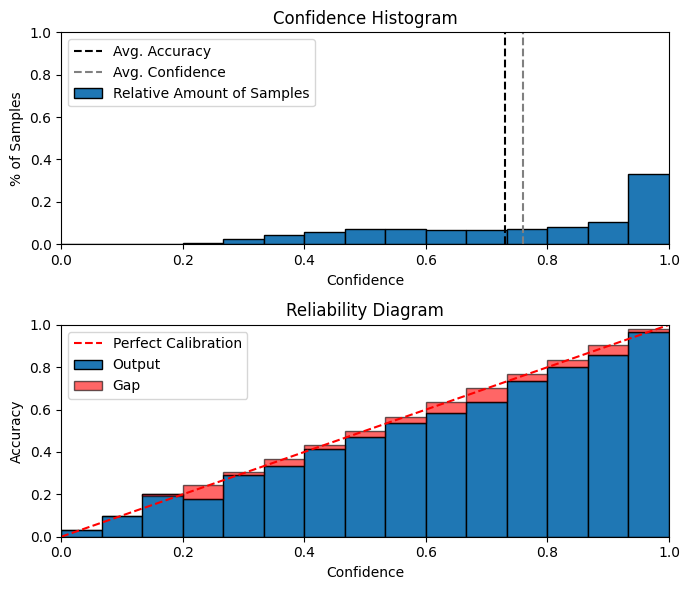

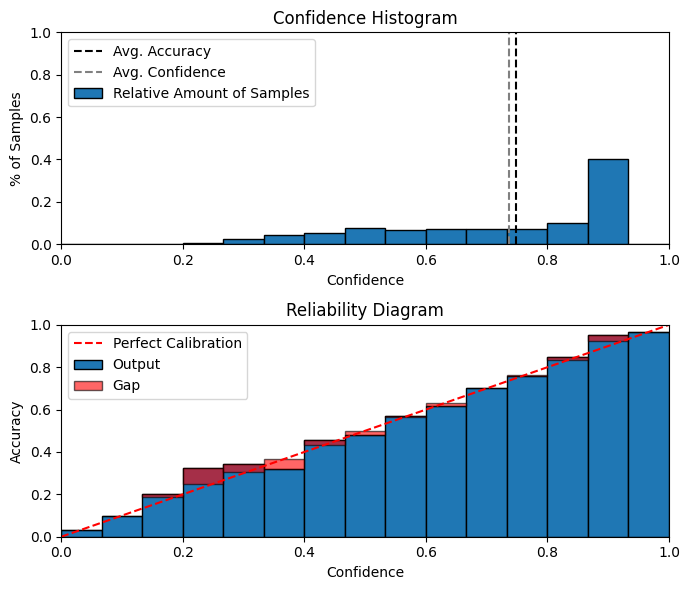

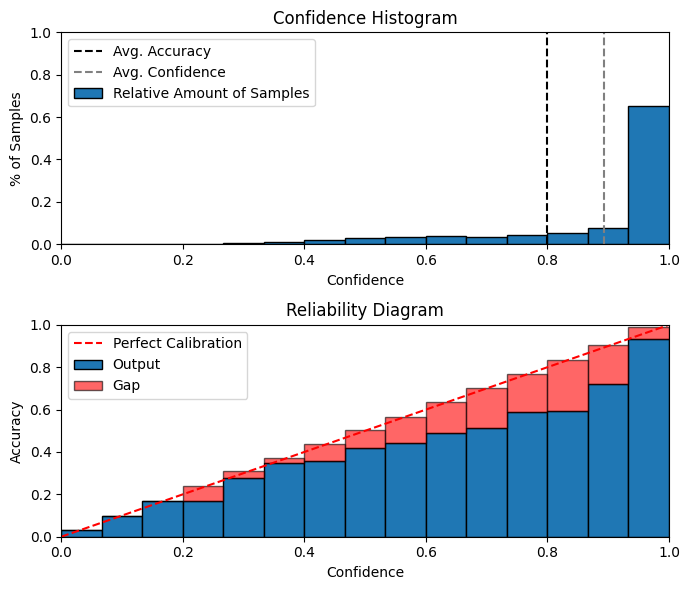

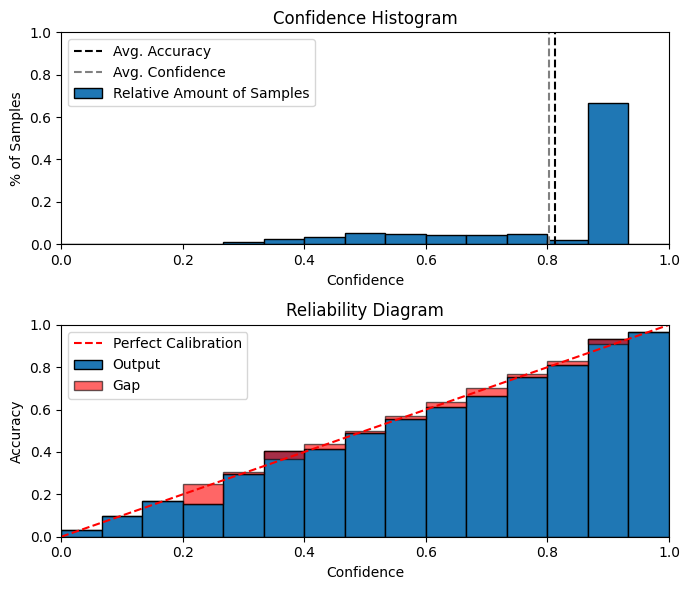

In [16]:
for name, model in models:

  evaluate_calibrate_plot(model, name, bbq)

**TemperatureScaling**

313/313 [==============================] - 1s 2ms/step
lenet Uncalibrated ECE: 0.0166
lenet Calibrated ECE: 0.0166
313/313 [==============================] - 3s 8ms/step
resnet Uncalibrated ECE: 0.0296
resnet Calibrated ECE: 0.0296
313/313 [==============================] - 9s 19ms/step
densenet Uncalibrated ECE: 0.0937
densenet Calibrated ECE: 0.0937


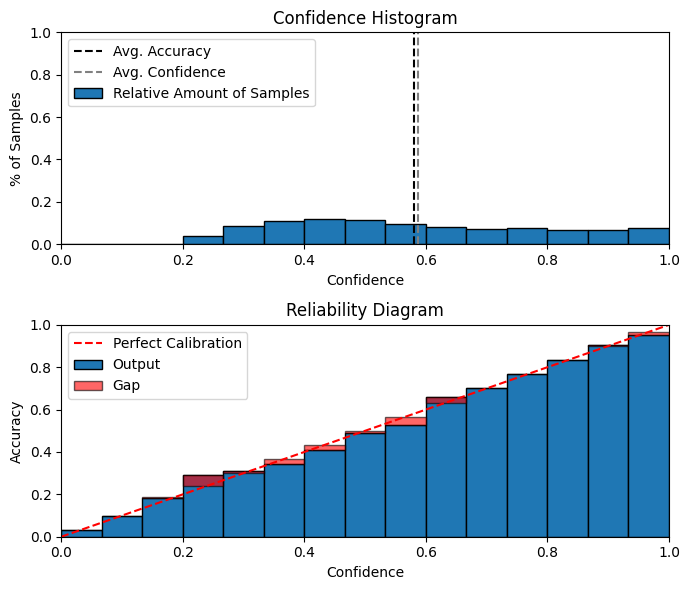

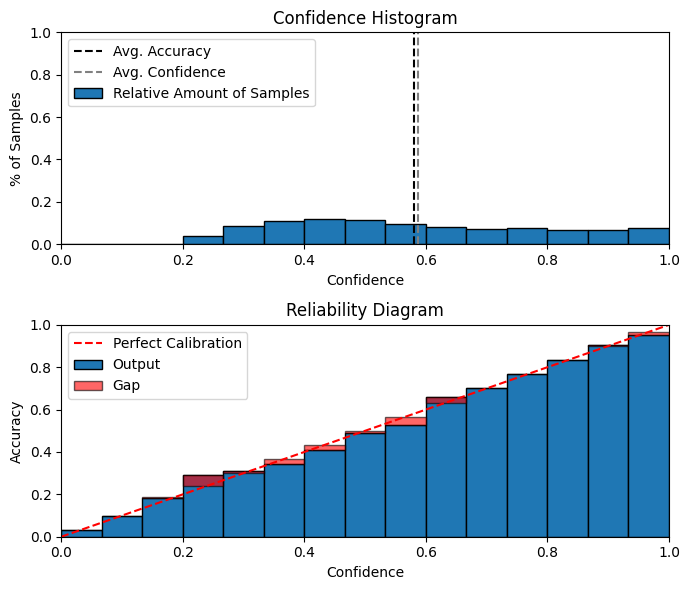

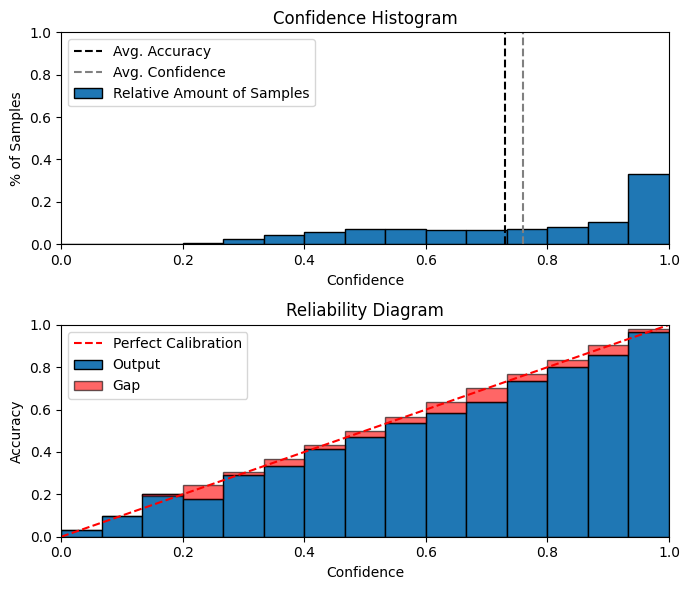

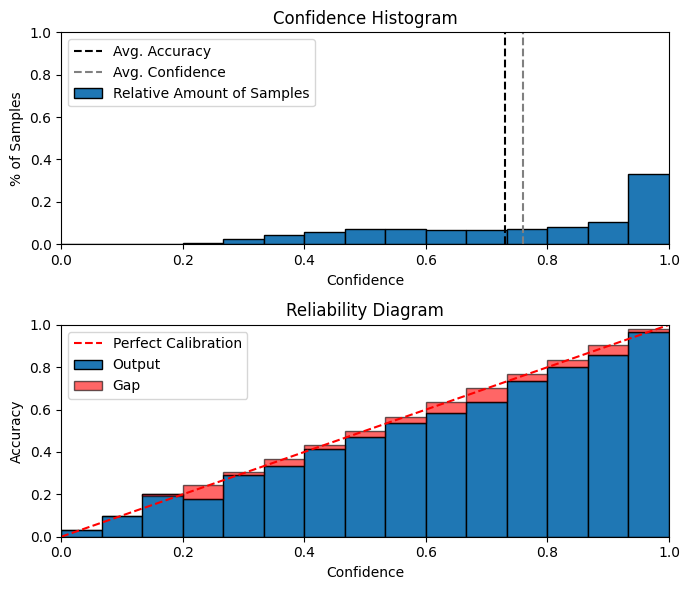

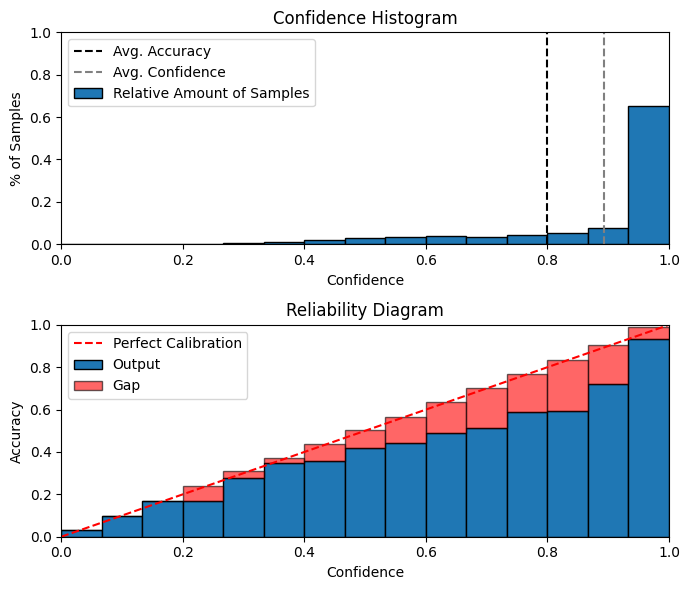

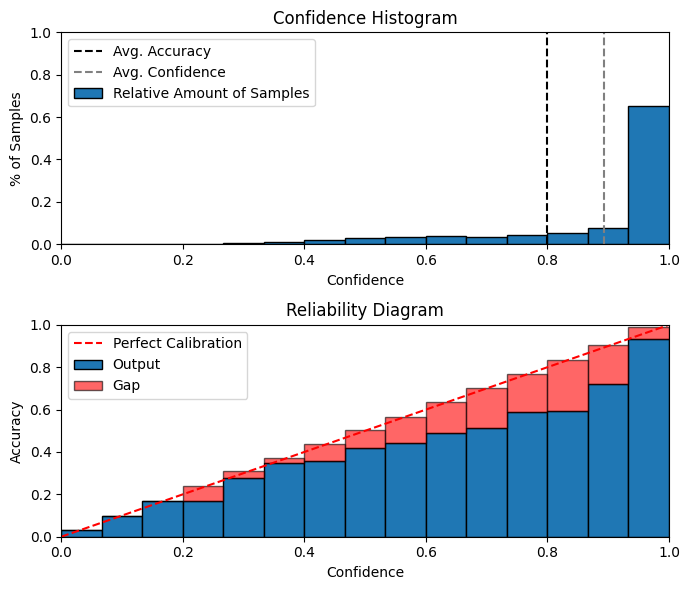

In [17]:
for name, model in models:

  evaluate_calibrate_plot(model, name, temperature_scaling)

**TemperatureScaling from Scratch**

Temperature scaling : lenet
Temperature Initial value:1.0
Temperature Final value:1.0245229005813599
Uncalibrated ECE: 0.0170
Calibrated ECE: 0.0148
Temperature scaling : resnet
Temperature Initial value:1.0
Temperature Final value:1.1080622673034668
Uncalibrated ECE: 0.0296
Calibrated ECE: 0.0077
Temperature scaling : densenet
Temperature Initial value:1.0
Temperature Final value:1.7050166130065918
Uncalibrated ECE: 0.0937
Calibrated ECE: 0.0079


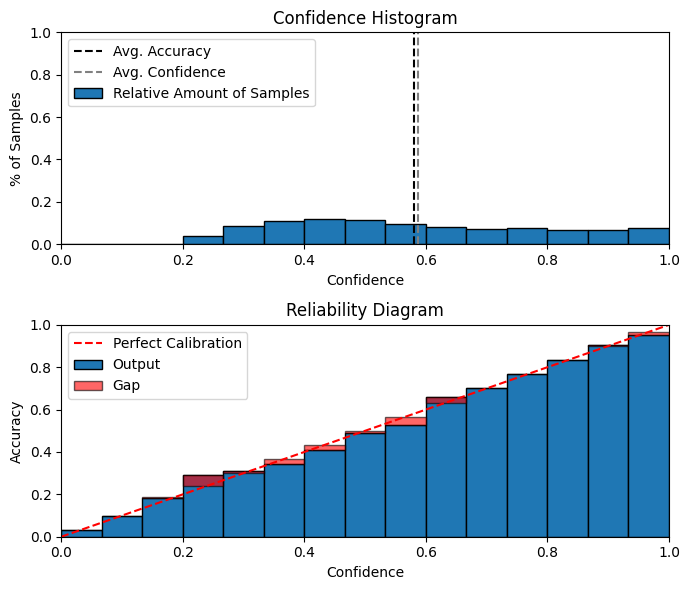

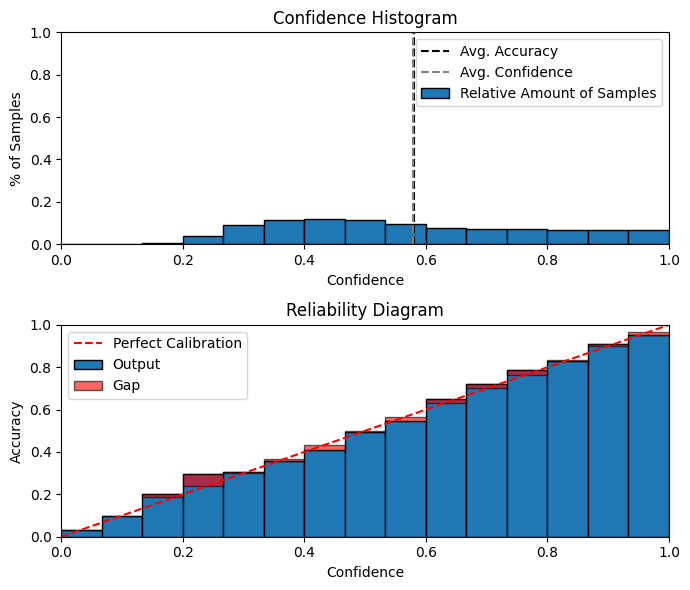

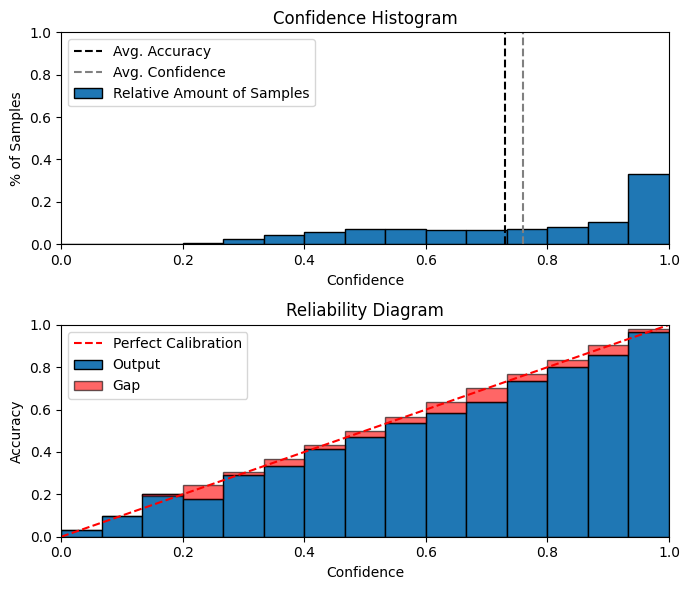

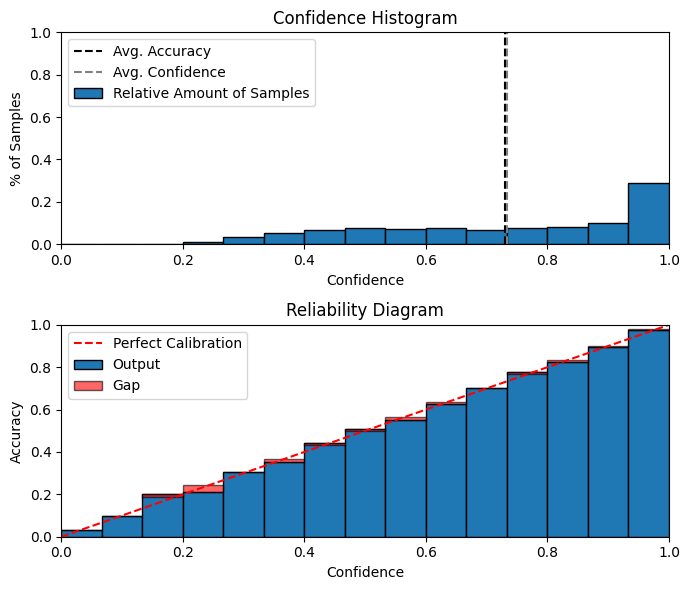

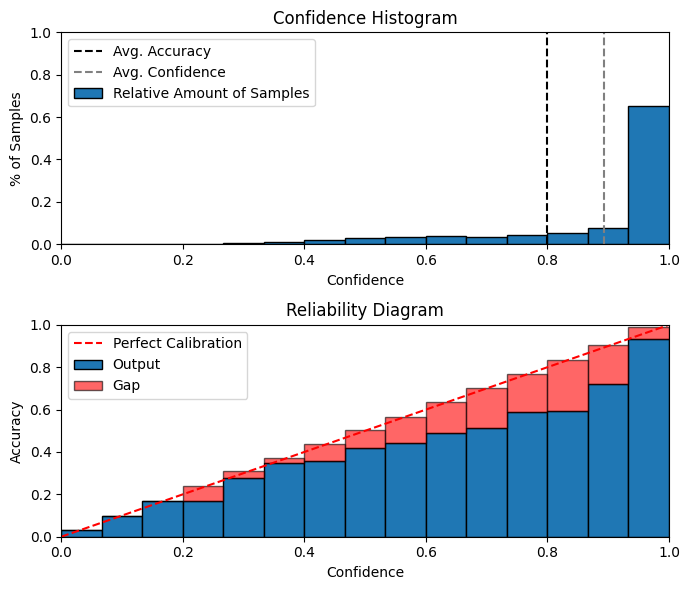

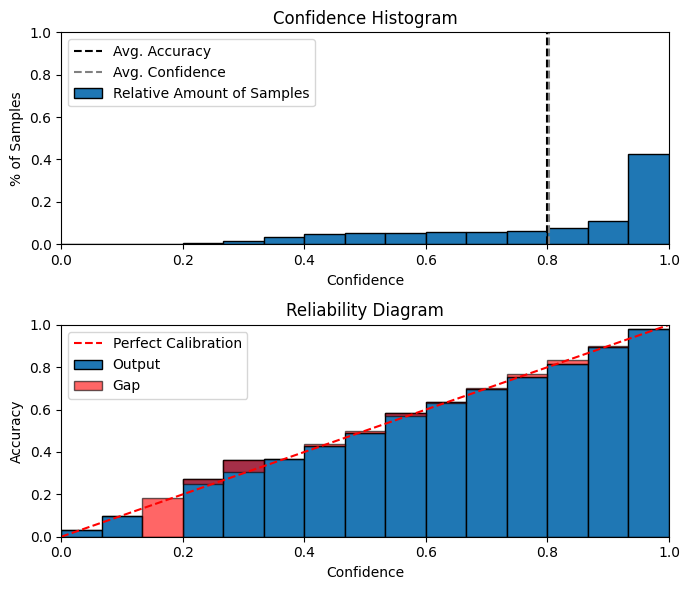

In [18]:
for name, model in models:

  print(f"Temperature scaling : {name}")

  temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32)
  logits = model(test_images).numpy()

  def compute_loss():

    logits_w_temp = tf.math.divide(logits, temp)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      tf.convert_to_tensor(test_labels), logits_w_temp
    ))

    return loss

  optimizer = tf.optimizers.Adam(learning_rate=0.01)

  print(f"Temperature Initial value:{temp.numpy()}")

  for i in range (500):
    opts = optimizer.minimize(compute_loss, var_list=[temp])

  print(f"Temperature Final value:{temp.numpy()}")
  # ECE result after calibration
  logits_w_temp = tf.math.divide(logits, temp)


  confidences = tf.nn.softmax(logits).numpy()

  calibrated_predictions = tf.nn.softmax(logits_w_temp).numpy()

  ground_truth = np.argmax(test_labels, axis=1)


  uncalibrated_score = ece.measure(confidences, ground_truth)
  calibrated_score = ece.measure(calibrated_predictions, ground_truth)

  # Plot
  diagram.plot(confidences, ground_truth, name=f"{name}_TempS_Uncalibrated.png")
  diagram.plot(calibrated_predictions, ground_truth, name=f"{name}_TempS_Calibrated.png")

  # Résultats
  print(f"Uncalibrated ECE: {uncalibrated_score:.4f}")
  print(f"Calibrated ECE: {calibrated_score:.4f}")


